# Part 1: MLP Model for Prediction

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import pandas as pd

In [3]:
# 1. Load your dataset
data = pd.read_csv("Datasets.csv")  # Replace with your actual file path

In [4]:
# 2. Separate features (X/params) and target (y/poisson)
params = data.iloc[:, :-1]
poisson = data.iloc[:,-1:]


In [5]:
# 3. Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(params, poisson, test_size=0.2, random_state=42)

In [6]:
# 4. Scale the features and the target
feature_scaler = StandardScaler()
X_train_scaled = feature_scaler.fit_transform(X_train)
X_test_scaled = feature_scaler.transform(X_test)

target_scaler = StandardScaler()
y_train_scaled = target_scaler.fit_transform(y_train)
y_test_scaled = target_scaler.transform(y_test)


In [7]:
# 5. Create PyTorch Datasets
class ReentrantDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

train_dataset = ReentrantDataset(X_train_scaled, y_train_scaled)
test_dataset = ReentrantDataset(X_test_scaled, y_test_scaled)


In [8]:
# 6. Create DataLoaders
batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size)


In [9]:
# 7. Define the MLP Model
class PoissonPredictor(nn.Module):
    def __init__(self, input_size):
        super(PoissonPredictor, self).__init__()
        self.fc1 = nn.Linear(input_size, 64)
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(64, 32)
        self.relu2 = nn.ReLU()
        self.fc3 = nn.Linear(32, 16)
        self.relu3 = nn.ReLU()
        self.fc_out = nn.Linear(16, 1)

    def forward(self, x):
        x = self.relu1(self.fc1(x))
        x = self.relu2(self.fc2(x))
        x = self.relu3(self.fc3(x))
        x = self.fc_out(x)
        return x

input_size = X_train_scaled.shape[1]  # Number of features
model = PoissonPredictor(input_size)


In [10]:
# 8. Define Loss Function and Optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


In [11]:
# 9. Training Loop
epochs = 100
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

for epoch in range(epochs):
    model.train()
    train_loss = 0
    for inputs, targets in train_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * inputs.size(0)
    train_loss /= len(train_loader.dataset)

    model.eval()
    val_loss = 0
    with torch.no_grad():
        for inputs, targets in test_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            val_loss += loss.item() * inputs.size(0)
    val_loss /= len(test_loader.dataset)

    print(f'Epoch {epoch+1}/{epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}')


Epoch 1/100, Train Loss: 0.5522, Val Loss: 0.2514
Epoch 2/100, Train Loss: 0.1307, Val Loss: 0.0631
Epoch 3/100, Train Loss: 0.0410, Val Loss: 0.0292
Epoch 4/100, Train Loss: 0.0233, Val Loss: 0.0187
Epoch 5/100, Train Loss: 0.0165, Val Loss: 0.0133
Epoch 6/100, Train Loss: 0.0123, Val Loss: 0.0107
Epoch 7/100, Train Loss: 0.0103, Val Loss: 0.0086
Epoch 8/100, Train Loss: 0.0083, Val Loss: 0.0068
Epoch 9/100, Train Loss: 0.0075, Val Loss: 0.0069
Epoch 10/100, Train Loss: 0.0069, Val Loss: 0.0058
Epoch 11/100, Train Loss: 0.0061, Val Loss: 0.0049
Epoch 12/100, Train Loss: 0.0053, Val Loss: 0.0043
Epoch 13/100, Train Loss: 0.0045, Val Loss: 0.0039
Epoch 14/100, Train Loss: 0.0046, Val Loss: 0.0057
Epoch 15/100, Train Loss: 0.0040, Val Loss: 0.0058
Epoch 16/100, Train Loss: 0.0038, Val Loss: 0.0031
Epoch 17/100, Train Loss: 0.0036, Val Loss: 0.0042
Epoch 18/100, Train Loss: 0.0034, Val Loss: 0.0036
Epoch 19/100, Train Loss: 0.0033, Val Loss: 0.0033
Epoch 20/100, Train Loss: 0.0033, Val Lo

In [12]:
# 10. Evaluate the Model (Optional)
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

model.eval()
y_pred_list = []
y_true_list = []
with torch.no_grad():
    for inputs, targets in test_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        outputs = model(inputs)
        y_pred = target_scaler.inverse_transform(outputs.cpu().numpy())
        y_true = target_scaler.inverse_transform(targets.cpu().numpy())
        y_pred_list.extend(y_pred)
        y_true_list.extend(y_true)

r2 = r2_score(y_true_list, y_pred_list)
mae = mean_absolute_error(y_true_list, y_pred_list)
rmse = mean_squared_error(y_true_list, y_pred_list, squared=False)

print(f'R-squared on Test Set: {r2:.4f}')
print(f'MAE on Test Set: {mae:.4f}')
print(f'RMSE on Test Set: {rmse:.4f}')

R-squared on Test Set: 0.9987
MAE on Test Set: 0.0034
RMSE on Test Set: 0.0049


/opt/homebrew/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


# Part 2: Symbolic Regression with PySR

In [66]:
import numpy
import sympy
import pysr
from pysr import PySRRegressor
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

In [14]:
# 1. Load your dataset again
data_sr = pd.read_csv("Datasets.csv")

In [15]:
# 2. Separate features (X/params) and target (y/poisson)
params_sr = data.iloc[:, :-1]
poisson_sr = data.iloc[:,-1:]


In [16]:
# 3. Split data into training and testing sets (same split as before for comparison)
X_train_sr, X_test_sr, y_train_sr, y_test_sr = train_test_split(params_sr, poisson_sr, test_size=0.2, random_state=42)


In [20]:
# 4. Initialize and run PySR
model_sr = PySRRegressor(
    # n_features=X_train_sr.shape[1], # NOTE might not be necessary since we're making a first pass of training on all features. revisit later to do term reduction
    # feature_names=['slant_length', 'thickness', 'angle', 'vertical_length'],
    populations=5,
    population_size=50,      # number of individuals per population
    # loss='mse', # NOTE can't specify a loss function as a string, needs to be custom julia code
    niterations=100,
    # You can specify the mathematical operations to use
    # default_operations=['+', '-', '*', '/'],
    # extra_sympy_mappings={'sin': 'sin', 'cos': 'cos'}, # Example for trigonometric functions
    # unary_operators=[np.exp, np.log, 'abs', 'sin', 'cos'], # Example for unary operators
    # binary_operators=['+', '-', '*', '/'],
    # complexity_of_operators={'*': 1, '/': 2, '+': 1, '-': 1, 'exp': 3, 'log': 3, 'sin': 2, 'cos': 2, 'abs': 1},
    random_state=42,
    procs=4                 # Number of CPU cores to use
)

print("\nStarting Symbolic Regression...")
model_sr.fit(X_train_sr, y_train_sr, variable_names=['slant_length', 'thickness', 'angle', 'vertical_length'])

/opt/homebrew/anaconda3/lib/python3.12/site-packages/pysr/sr.py:2776: UserWarning: Note: it looks like you are running in Jupyter. The progress bar will be turned off.
  warnings.warn(
/opt/homebrew/anaconda3/lib/python3.12/site-packages/pysr/sr.py:1556: UserWarning: `variable_names` has been reset to `None` as `X` is a DataFrame. Using DataFrame column names instead.
  warnings.warn(
/opt/homebrew/anaconda3/lib/python3.12/site-packages/pysr/sr.py:1566: UserWarning: Spaces in DataFrame column names are not supported. Spaces have been replaced with underscores. 
Please rename the columns to valid names.
  warnings.warn(
Compiling Julia backend...



Starting Symbolic Regression...


/opt/homebrew/anaconda3/lib/python3.12/site-packages/pysr/sr.py:1850: UserWarning: Note: Setting `random_state` without also setting `deterministic=True` and `parallelism='serial'` will result in non-deterministic searches.
  warnings.warn(
[ Info: Started!
[ Info: Final population:
[ Info: Results saved to:


PySRRegressor.equations_ = [
	    pick     score                                           equation  \
	0         0.000000                                        -0.05737876   
	1         0.144818                  Slant_cell_length * -0.0070060543   
	2         0.145312     (Slant_cell_length * -0.01748692) + 0.14425412   
	3         0.030893  (Cell_thickness - (Slant_cell_length + -5.1328...   
	4         0.048585  ((Slant_cell_length * -2.5450706) / (Cell_angl...   
	5         0.033596  (Slant_cell_length * ((-93.18063 / (Cell_angle...   
	6         0.000806  ((Slant_cell_length * ((-93.18063 / (Cell_angl...   
	7         0.040067  Slant_cell_length * (((Slant_cell_length / (Ce...   
	8         0.004398  (Slant_cell_length * -0.11337864) * ((Slant_ce...   
	9         0.084888  Slant_cell_length * (((Slant_cell_length / (((...   
	10  >>>>  0.137801  ((((Slant_cell_length / ((Slant_cell_length * ...   
	11        0.013573  ((Slant_cell_length * (Vertical_cell_length * ...   
	12        0.005273  ((Cell_thickness / -0.9923655) + ((Slant_cell_...   
	13        0.002380  (((Cell_thickness / -0.9923655) + (Slant_cell_...   
	
	        loss  complexity  
	0   0.017885           1  
	1   0.013388           3  
	2   0.010011           5  
	3   0.009411           7  
	4   0.008540           9  
	5   0.007985          11  
	6   0.007972          13  
	7   0.007358          15  
	8   0.007294          17  
	9   0.006155          19  
	10  0.004672          21  
	11  0.004547          23  
	12  0.004499          25  
	13  0.004478          27  
]


Expressions evaluated per second: 7.270e+04


In [22]:
model_sr.sympy()

(Slant_cell_length*0.17546645*Vertical_cell_length/(Cell_angle + Slant_cell_length*(Vertical_cell_length/(Cell_angle - Slant_cell_length) - 3.8501096)) - 2.687245)*(-0.031911876)

# Validate `outputs/20250503_224212_5kTnhb`

In [50]:
# TODO write a function that automatically parses model output into an equation that can be fed the points of a dataset.
# print(model_sr.pytorch())

equations = list(model_sr.equations_['equation'])
print(equations)


['-0.05737876', 'Slant_cell_length * -0.0070060543', '(Slant_cell_length * -0.01748692) + 0.14425412', '(Cell_thickness - (Slant_cell_length + -5.132899)) / Cell_angle', '((Slant_cell_length * -2.5450706) / (Cell_angle - -79.57211)) + 0.15528256', '(Slant_cell_length * ((-93.18063 / (Cell_angle - -604.65076)) - -0.12133303)) - -0.16308124', '((Slant_cell_length * ((-93.18063 / (Cell_angle - -604.65076)) - -0.12133303)) + -0.0031494976) - -0.16308124', 'Slant_cell_length * (((Slant_cell_length / (Cell_angle + (Vertical_cell_length / (Cell_angle * 0.05095026)))) + -0.12862825) * -0.11733428)', '(Slant_cell_length * -0.11337864) * ((Slant_cell_length / ((Vertical_cell_length / (Cell_angle * 0.05049234)) + (Cell_angle - 3.0786963))) + -0.1332625)', 'Slant_cell_length * (((Slant_cell_length / ((((Vertical_cell_length + Slant_cell_length) / (Cell_angle * 0.04730608)) + -38.675495) + Cell_angle)) + -0.21917334) * -0.083359696)', '((((Slant_cell_length / ((Slant_cell_length * ((Vertical_cell_l

Index(['Slant cell length', 'Cell thickness', 'Cell angle',
       'Vertical cell length', 'Poisson's ratio'],
      dtype='object')


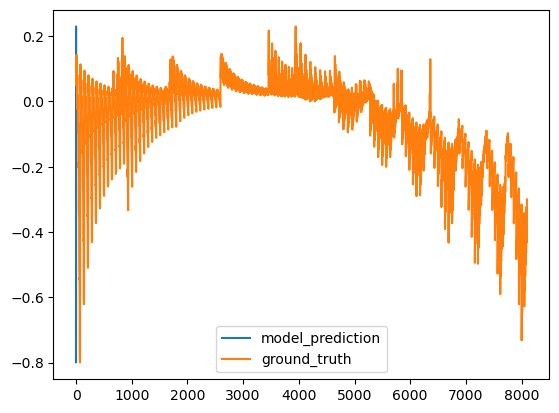

/opt/homebrew/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


R-squared on Test Set: 0.7371
MAE on Test Set: 0.0475
RMSE on Test Set: 0.0686


In [67]:
print(data.columns)

def validate_1st_run(dataset, equation=None):
    """
    take in the raw set of geometry<->poisson ratio mappings
    and return a plot of SR model predictions.
    """
    slant_cell_length = numpy.asarray(dataset['Slant cell length'])
    cell_thickness = numpy.asarray(dataset['Cell thickness'])
    cell_angle = numpy.asarray(dataset['Cell angle'])
    vertical_cell_length = numpy.asarray(dataset['Vertical cell length'])
    poisson_ratio = numpy.asarray(dataset['Poisson\'s ratio'])

    model_predictions = []
    for idx in range(len(dataset)):
        model_predictions.append(run_1_SR(slant_cell_length=slant_cell_length[idx],cell_thickness=cell_thickness[idx],cell_angle=cell_angle[idx], vertical_cell_length=vertical_cell_length[idx]))
    
    plt.plot(model_predictions, poisson_ratio)
    plt.plot(poisson_ratio)
    plt.legend(['model_prediction','ground_truth'])
    plt.show()

    r2 = r2_score(poisson_ratio, model_predictions)
    mae = mean_absolute_error(poisson_ratio, model_predictions)
    rmse = mean_squared_error(poisson_ratio, model_predictions, squared=False)

    print(f'R-squared on Test Set: {r2:.4f}')
    print(f'MAE on Test Set: {mae:.4f}')
    print(f'RMSE on Test Set: {rmse:.4f}')
        

# TODO make automated function generation work with this below block of code. want to go from sympy --> actionable equation  
def run_1_SR(slant_cell_length, cell_thickness, cell_angle, vertical_cell_length): 
    poisson_prediction = (slant_cell_length*0.17546645*vertical_cell_length/(cell_angle + slant_cell_length*(vertical_cell_length/(cell_angle - slant_cell_length) - 3.8501096)) - 2.687245)*(-0.031911876)
    return poisson_prediction
    

validate_1st_run(data)

